In [1]:
import data_generator as tsg
from datetime import datetime, timedelta

from keras import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from numpy import array, zeros

from matplotlib import pyplot

c:\Users\yaggod\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


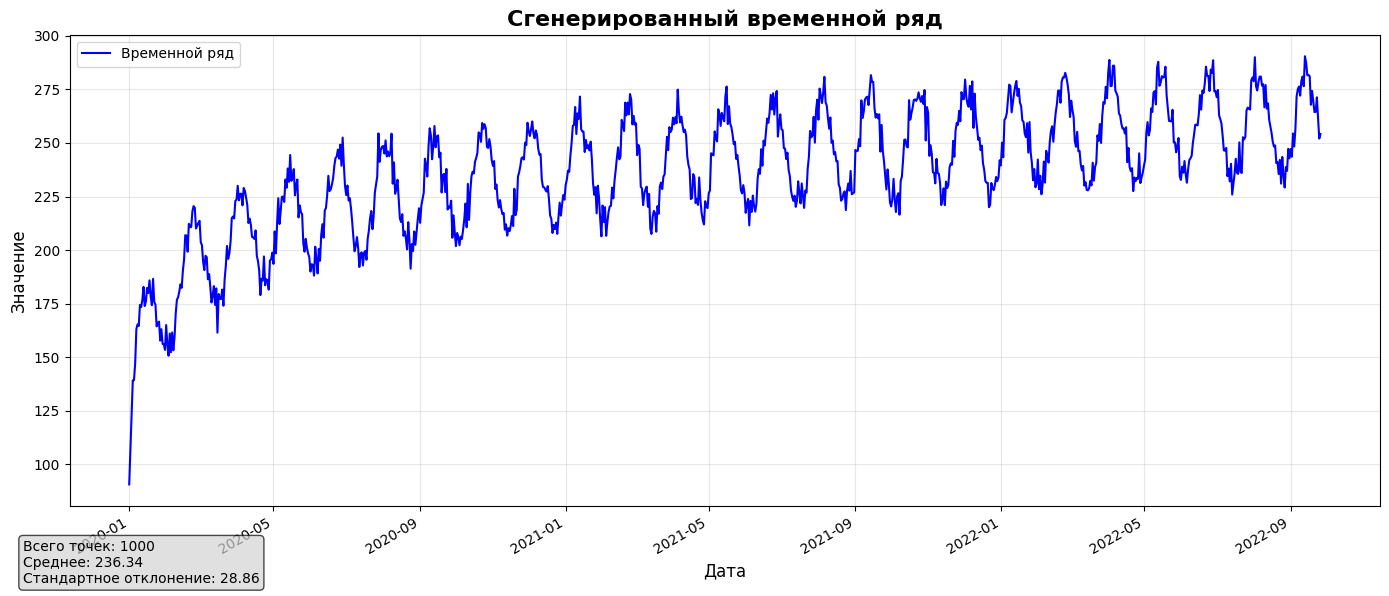

In [2]:
dates_strings, values = tsg.generate_time_series(n_points=1000, seed=42)
values = values.tolist()
dates = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in dates_strings]
tsg.plot_time_series(dates_strings, values)

In [3]:
def split_sequence(sequence : list[float], n_steps : int) -> tuple[list[float], float]:
    X = []
    y = []

    for i in range(len(sequence) - n_steps):
        X.append(sequence[i:i+n_steps])
        y.append(sequence[i + n_steps])
    return array(X), array(y)

In [4]:
n_steps = 120
n_features = 1

X, y = split_sequence(values, n_steps)
X = X.reshape(len(X), n_steps, n_features)

In [5]:
model= Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, 'relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [6]:
model.fit(X, y, epochs=1000, verbose=0)

In [7]:
n_points = 200

for i in range(n_points):
    data_for_prediction = array(values[-n_steps:]).reshape(1, n_steps, 1)
    result = model.predict(data_for_prediction, batch_size=1, verbose=0)
    values.append(result[0][0])


In [8]:
new_values = values[-n_points:]
new_dates = [(dates[-1] + timedelta(days=i)) for i in range(n_points)]

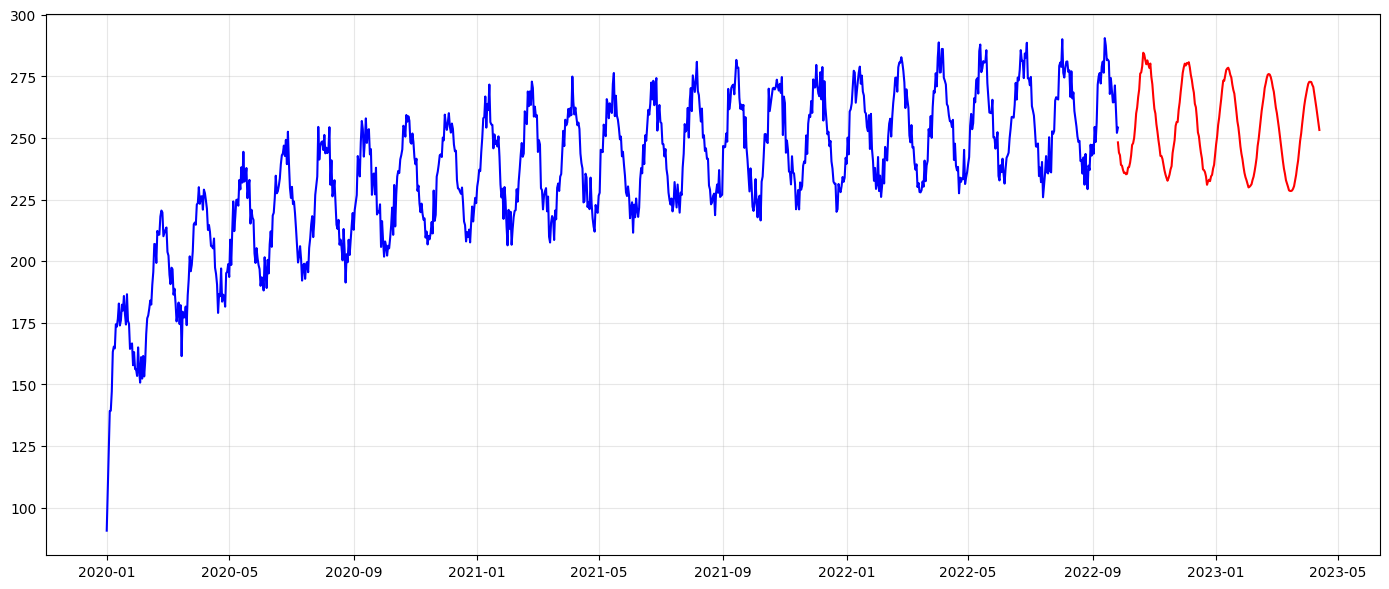

In [9]:
pyplot.figure(figsize=(14, 6))

pyplot.plot(dates[:1000], values[:1000], color='b', linewidth=1.5)
pyplot.plot(new_dates, new_values, color='r', linewidth=1.5)
pyplot.grid(True, alpha=0.3)

pyplot.tight_layout()
pyplot.show()